<a href="https://colab.research.google.com/github/buisonanh/phishing_urls_detection/blob/main/phishing_urls_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prepare Data**

In [2]:
import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
legit = pd.read_csv("datasets/legitimate_urls.csv")
phishing = pd.read_csv("datasets/phishing_urls.csv")

In [4]:
legit.drop_duplicates()
phishing.drop_duplicates()

print(legit.info())
print()
print(phishing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31085 entries, 0 to 31084
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     31085 non-null  object
dtypes: object(1)
memory usage: 243.0+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56591 entries, 0 to 56590
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     56591 non-null  object
dtypes: object(1)
memory usage: 442.2+ KB
None


In [5]:
# add a 'status' column to the dataframes
legit["status"] = "legitimate"
phishing["status"] = "phishing"

print(legit)
# combine the two dataframes
df = pd.concat([legit, phishing], ignore_index=True)

# shuffle the dataframe's rows randomly
df = df.sample(frac=1, random_state=42) # Set random_state to an integer for reproducibility

df.info()

                      url      status
0          000webhost.com  legitimate
1               007go.com  legitimate
2                 010.com  legitimate
3        022menchuang.net  legitimate
4           050anshin.com  legitimate
...                   ...         ...
31080       crestbook.com  legitimate
31081          fumbbl.com  legitimate
31082          proplay.ru  legitimate
31083    jeuxdecartes.net  legitimate
31084  molehillempire.com  legitimate

[31085 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87676 entries, 61210 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     87676 non-null  object
 1   status  87676 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [6]:
# Identify duplicate rows
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicates: {num_duplicates}")

df = df.drop_duplicates()

duplicates = df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicates: {num_duplicates}")


Number of duplicates: 220
Number of duplicates: 0


In [7]:
# delete symbols
import re
df["url"] = df["url"].apply(lambda x: re.sub('[/\.;?=https:\']', ' ', x))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87456 entries, 61210 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     87456 non-null  object
 1   status  87456 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [9]:
df.isnull().sum()
df.dropna(inplace = True)

df.head(10)

,url,status
61210,u -rediliver makeyourw com u veri...,phishing
8914,ren acar fr,legitimate
69536,587c88df-b417-4d76-9193-26ff31ef6f64 i...,phishing
62196,www kuerennkaycoa o co j kuercnnkaycea...,phishing
36231,qrco de bd 7VB rackid eCY j8 V9ffkdrY...,phishing
4199,free a ern com,legitimate
14680,zeeuw arc ief nl,legitimate
42990,u en e-webinfo-login 199-188-203-93 c ...,phishing
44582,7 95-214-24-226 c ra id com,phishing
73924,jofra afari co ke #,phishing


In [10]:
"""
# assume `data` is a pandas DataFrame with columns "url" and "status"
counts = df["status"].value_counts()

# print the counts for each category
print(counts)
"""

'\n# assume `data` is a pandas DataFrame with columns "url" and "status"\ncounts = df["status"].value_counts()\n\n# print the counts for each category\nprint(counts)\n'

# **Vectorizing and Encoding**

In [11]:
# Data selection
feature_df = df['url']
status_df = df['status']

# Transform data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Vectorize URLs
vectorizer = CountVectorizer()
feature_vec = vectorizer.fit_transform(feature_df)

# Encode status column
label_encoder = LabelEncoder()
status_arr = label_encoder.fit_transform(status_df)

# Get class labels and corresponding encoded values
class_labels = label_encoder.classes_
class_encodings = label_encoder.transform(class_labels)

# Print class labels and their corresponding encoded values
for label, encoding in zip(class_labels, class_encodings):
    print(f"{encoding} -> {label}")


0 -> legitimate
1 -> phishing


In [12]:
#print(feature_vec)

In [13]:
"""
from imblearn.over_sampling import RandomOverSampler

# create a RandomOverSampler object and fit it to the data
oversampler = RandomOverSampler(random_state=42)
feature_vec_balanced, status_arr_balanced = oversampler.fit_resample(feature_vec, status_arr)

# check the new class distribution
pd.Series(status_arr_balanced).value_counts()
"""

'\nfrom imblearn.over_sampling import RandomOverSampler\n\n# create a RandomOverSampler object and fit it to the data\noversampler = RandomOverSampler(random_state=42)\nfeature_vec_balanced, status_arr_balanced = oversampler.fit_resample(feature_vec, status_arr)\n\n# check the new class distribution\npd.Series(status_arr_balanced).value_counts()\n'

# **Logistic Regression**

In [14]:
# chia tap train, test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_vec, status_arr, test_size=0.25, random_state=42)

print('Train: ', x_train.shape[0])
print('Test: ', x_test.shape[0])

Train:  65592
Test:  21864


In [15]:

# modeling lbfgs
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C= 0.01, class_weight= None, max_iter= 100, penalty= 'l2',random_state=42)
lr_lbfgs = logreg.fit(x_train,y_train)


In [16]:
"""
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'max_iter': [100, 500, 1000],
              'class_weight': [None, 'balanced']}

grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


# Output:
# Best parameters: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2'}
# Best cross-validation score: 0.9286404335532517
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\'C\': [0.001, 0.01, 0.1, 1, 10],\n              \'penalty\': [\'l1\', \'l2\'],\n              \'max_iter\': [100, 500, 1000],\n              \'class_weight\': [None, \'balanced\']}\n\ngrid_search = GridSearchCV(LogisticRegression(solver=\'lbfgs\'),\n                           param_grid,\n                           cv=5,\n                           scoring=\'accuracy\',\n                           n_jobs=-1)\n\ngrid_search.fit(x_train, y_train)\n\nprint(f"Best parameters: {grid_search.best_params_}")\nprint(f"Best cross-validation score: {grid_search.best_score_}")\n\n\n# Output:\n# Best parameters: {\'C\': 10, \'class_weight\': None, \'max_iter\': 100, \'penalty\': \'l2\'}\n# Best cross-validation score: 0.9286404335532517\n'

In [17]:
y_pred=logreg.predict(x_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [18]:
from sklearn.metrics import jaccard_score
print(f"Jaccard score: {jaccard_score(y_test, y_pred,pos_label=0)}")

Jaccard score: 0.6342441185779091


In [19]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")


Accuracy: 0.84
F1 score: 0.88


In [20]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 6012,  1716],
       [ 1751, 12385]], dtype=int64)

Matplotlib is building the font cache; this may take a moment.


Text(0.5, 427.9555555555555, 'Predicted label')

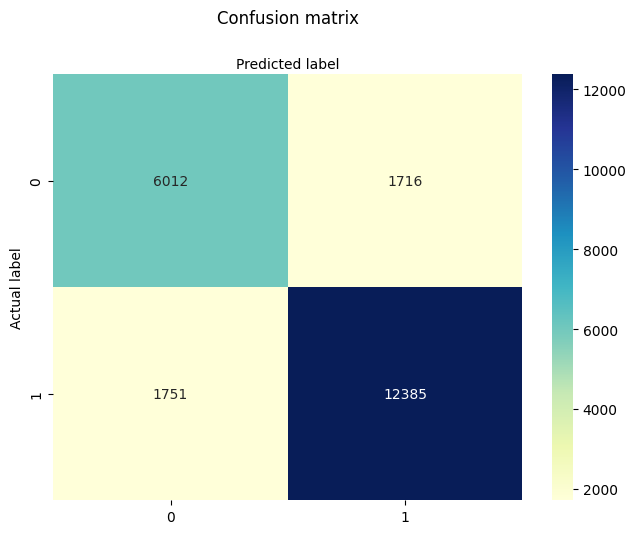

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [22]:
"""
new_url = input('Enter an URL to test: ')

# Transform features into same format as training data
new_vector = vectorizer.transform([new_url])

# Make prediction using trained model
prediction = logreg.predict(new_vector)

if prediction[0] == 0:
  print('Legitimate')
else:
  print('Phishing')
"""

"\nnew_url = input('Enter an URL to test: ')\n\n# Transform features into same format as training data\nnew_vector = vectorizer.transform([new_url])\n\n# Make prediction using trained model\nprediction = logreg.predict(new_vector)\n\nif prediction[0] == 0:\n  print('Legitimate')\nelse:\n  print('Phishing')\n"

# **(Test)**

In [23]:
test_df = pd.read_csv('datasets/publish_test.csv')
test_df.head(30)

,x,y,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,http://newmatdesign.ro/wp-admin/wewe/YAHOO/ya....,1,NaN,NaN,NaN
1,http://ca.linkedin.com/directory/people/ca/pou...,0,NaN,NaN,NaN
2,http://www.ccent.com.au/index.php?option=com_m...,1,NaN,NaN,NaN
3,http://applerugs.co.uk/rugs/product_info.php?p...,1,NaN,NaN,NaN
4,http://mo-artworks.com/blog/diverse-videos/ein...,1,NaN,NaN,NaN
5,http://spoke.com/info/pF2WnMN/ZachTrimmer,0,NaN,NaN,NaN
6,http://www.ricardoitalo.com.br/portal/index.ph...,1,NaN,NaN,NaN
7,http://sexshop-bg.biz/products?page=shop.produ...,1,NaN,NaN,NaN
8,http://www.beriva.lt/index.html?di=akcijos&R=1...,1,NaN,NaN,NaN
9,http://ma.facevena.xyz/app/facebook.com/?lang=...,1,NaN,NaN,NaN


In [24]:
test = test_df[['x','y']]

test.isnull().sum()
test.dropna()

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x       100 non-null    object
 1   y       100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [25]:
indexValue = test[test['y'] == 'continue=to&amp'].index
test.drop(indexValue , inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_17084\2425266588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(indexValue , inplace=True)


In [26]:
x_t = test['x']
y_t = test['y'].astype(int)


x_t = vectorizer.transform(x_t)
y_t = np.asarray(y_t)
print(y_t)

y_pred_t = logreg.predict(x_t)
print(y_pred_t)

[1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0
 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1]
[1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0
 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1]


In [27]:
logreg.score(x_t, y_t)

0.8181818181818182

In [28]:
from sklearn.metrics import jaccard_score
print(jaccard_score(y_t, y_pred_t,pos_label=0))

0.6842105263157895


In [29]:
accuracy = accuracy_score(y_t, y_pred_t)
f1 = f1_score(y_t, y_pred_t)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.82
F1 score: 0.82


Text(0.5, 427.9555555555555, 'Predicted label')

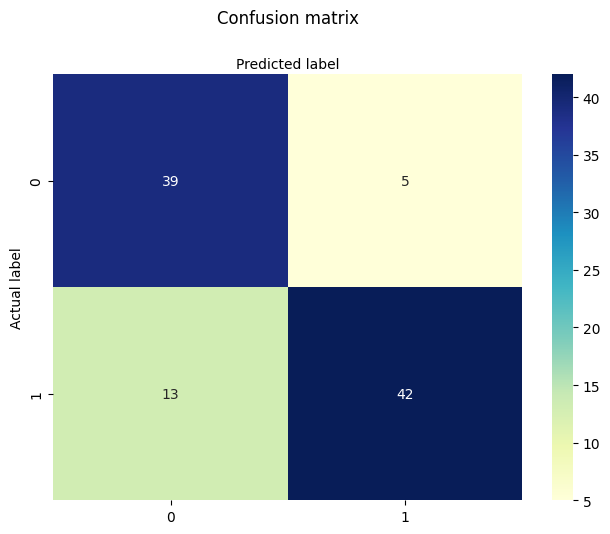

In [30]:
cnf_matrix = metrics.confusion_matrix(y_t, y_pred_t)
cnf_matrix

class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')